In [11]:
using DifferentialEquations
using LinearAlgebra
using Plots
using Interpolations
using Symbolics
using Symbolics: derivative


@variables xx[1:4] uu[1:1] qq[1:4]

H0 = [0 0 1 0;
      0 0 0 -1;
     -1 0 0 0;
      0 1 0 0]

H1 = [0 -1 0 0;
      1 0 0 0;
      0 0 0 -1;
      0 0 1 0]

H2 = [0 0 0 1;
      0 0 1 0;
      0 -1 0 0;
      -1 0 0 0]


f(xx,uu) = collect((H0 + sin(uu[1])*H1 + (1 - cos(uu[1]))*H2)*xx)

l(xx,uu) = 0.01/2*uu[1]^2

L(xx,uu,qq) = collect(l(xx,uu) + transpose(qq)*f(xx,uu))

function jacobian(dx, f, args...; inplace = false)
    f_sym = f(args...)
    fx_sym = cat(map(1:length(dx)) do i
        map(1:length(f_sym)) do j
            derivative(f_sym[j], dx[i])
        end
    end...; dims = ndims(f_sym)+1)

    return eval(build_function(fx_sym, args...)[inplace ? 2 : 1])
end

fx = jacobian(xx, f, xx, uu)
fu = jacobian(uu, f, xx, uu)


T = 15
tspan = (0.0,T)

dmu(mu,_,t) = 0*t

mu = solve(ODEProblem(dmu,0,tspan))

dal(al,_,t) = f(al,mu(t))

al0 = [1;0;0;0]

al = solve(ODEProblem(dal,al0,tspan))

function inprod(x)
    a = x[1:2]
    b = x[3:4]
    P = [a*a'+b*b' -(a*b'+b*a');
         a*b'+b*a' a*a'+b*b']
    return P
end

Pr_terminal(al) = I(4) - inprod(al)

    
Ar(t) = fx(al(t),mu(t))
Br(t) = fu(al(t),mu(t))
Qr(t) = I(4) - inprod(al(t))
Rr(t) = 1

Kr(Pr,Rr,Br)= Rr\(Br'*Pr)
    
Kr(t) = Kr(Pr(t),Rr(t),Br(t))

dPr(Pr,_,t) = Ar(T-t)'*Pr + Pr*Ar(T-t) - Kr(Pr,Rr(T-t),Br(T-t))'*Rr(T-t)*Kr(Pr,Rr(T-t),Br(T-t)) + Qr(T-t)
Pr(t) = Pr_back(T-t)
    
u(x,Kr,al,mu) = mu - (Kr*(x - al))[1]

u(t) = u(x(t),Kr(t),al(t),mu(t))
    
dx(x,_,t) = f(x,u(x,Kr(Pr(t),Rr(t),Br(t)),al(t),mu(t)))

x0 = [0;1;0;0]

dJ(_,_,t) = 0.01/2*u(t)^2

lx = jacobian(xx, l, xx, uu)
lu = jacobian(uu, l, xx, uu)

lxx = jacobian(xx, lx, xx, uu)
lxu = jacobian(uu, lx, xx, uu)
luu = jacobian(uu, lu, xx, uu)
    
P_terminal = I(4) - inprod([1 0 0 0])


A(t) = fx(x(t),u(t))
B(t) = fu(x(t),u(t))
a(t) = lx(x(t),u(t))
b(t) = lu(x(t),u(t))
Q(t) = lxx(x(t),u(t))
S(t) = lxu(x(t),u(t))
R(t) = luu(x(t),u(t))

dq(q,_,t) = (A(T-t) - B(T-t)*Kr(T-t))'*q + a(T-t) - Kr(T-t)'*b(T-t)

q(t) = q_back(T-t)

Lx = jacobian(xx, L, xx, uu, qq)
Lu = jacobian(uu, L, xx, uu, qq)

Lxx = jacobian(xx, Lx, xx, uu, qq)
Lxu = jacobian(uu, Lx, xx, uu, qq)
Luu = jacobian(uu, Lu, xx, uu, qq)


Qo(t) = Lxx(x(t),u(t),q(t))
So(t) = Lxu(x(t),u(t),q(t))
Ro(t) = Luu(x(t),u(t),q(t))


# GD
Ko(P,R,S,B)= R\(S' + B'*P)

Ko(t) = Ko(P(t),R(t),S(t),B(t))

dP(P,_,t) = A(T-t)'*P + P*A(T-t) - Ko(P,R(T-t),S(T-t),B(T-t))'*R(T-t)*Ko(P,R(T-t),S(T-t),B(T-t)) + Q(T-t)
P(t)=P_back(T-t)

PT = [0 0 0 0;
      0 1 0 0;
      0 0 0 0;
      0 0 0 1]

dr(r,_,t) = (A(T-t) - B(T-t)*Ko(T-t))'*r + a(T-t) - vec(Ko(T-t)'*b(T-t))
r(t)=r_back(T-t)

vo(R,B,r,b) = -R\(B'*r + b)

vo(t) = vo(R(t),B(t),r(t),b(t))

v(z,Ko,vo) = (-Ko*z) + vo

v(t) = v(z(t),Ko(t),vo(t))

dz(z,_,t) = A(t)*z + B(t)*v(z,Ko(t),vo(t))

z0 = 0*x0

dy1(_,_,t) = a(t)'*z(t) + b(t)'*v(t)

dy2(_,_,t) = z(t)'*Qo(t)*z(t) + (2*z(t)'*So(t)*v(t))'[1] + v(t)'*Ro(t)*v(t)

gamma = 1

al1(x,z)    = x + gamma*z
mu1(u,v)    = u + gamma*v[1]
u1(x1,Kr,al1,mu1) = mu1 - (Kr*(x1 - al1))[1]

al1(t) = x(t) + gamma*z(t)
mu1(t) = mu1(u(t),v(t))
u1(t) = u1(x1(t),Kr(t),al1(t),mu1(t));


dx1(x1,_,t) = f(x1,u1(x1,Kr(t),al1(x(t),z(t)),mu1(u(t),v(t))))
dJ1(_,_,t) = 0.01/2*u1(t)^2

# Newt
Ko2(P2,Ro,So,B)= Ro\(So' + B'*P2)

Ko2(t) = Ko2(P2(t),Ro(t),So(t),B(t))

dP2(P2,_,t) = A(T-t)'*P2 + P2*A(T-t) - Ko2(P2,Ro(T-t),So(T-t),B(T-t))'*Ro(T-t)*Ko2(P2,Ro(T-t),So(T-t),B(T-t)) + Qo(T-t)
P2(t)=P2_back(T-t)

P2T = [0 0 0 0;
      0 1 0 0;
      0 0 0 0;
      0 0 0 1]

dr2(r2,_,t) = (A(T-t) - B(T-t)*Ko2(T-t))'*r2 + a(T-t) - vec(Ko2(T-t)'*b(T-t))
r2(t)=r2_back(T-t)

vo2(Ro,B,r2,b) = -Ro\(B'*r2 + b)

vo2(t) = vo2(Ro(t),B(t),r2(t),b(t))

v2(z2,Ko2,vo2) = (-Ko2*z2) + vo2

v2(t) = v2(z2(t),Ko2(t),vo2(t))

dz2(z2,_,t) = A(t)*z2 + B(t)*v2(z2,Ko2(t),vo2(t))

z20 = 0*x0

dy12(_,_,t) = a(t)'*z2(t) + b(t)'*v2(t)

dy22(_,_,t) = z2(t)'*Qo(t)*z2(t) + (2*z2(t)'*So(t)*v2(t))'[1] + v2(t)'*Ro(t)*v2(t)

gamma = 1

al2(x,z2)    = x + gamma*z2
mu2(u,v2)    = u + gamma*v2[1]
u2(x2,Kr,al2,mu2) = mu2 - (Kr*(x2 - al2))[1]

al2(t) = x(t) + gamma*z2(t)
mu2(t) = mu2(u(t),v2(t))
u2(t) = u2(x2(t),Kr(t),al2(t),mu2(t));


dx2(x2,_,t) = f(x2,u2(x2,Kr(t),al2(x(t),z2(t)),mu2(u(t),v2(t))))
dJ2(_,_,t) = 0.01/2*u2(t)^2

dJ2 (generic function with 1 method)

In [12]:
global Pr_back
global x
global J
global h
global q_back
global P_back
global P2_back
global r_back
global r2_back
global z
global z2
global y1
global y12
global y2
global y22
global Dh
global Dg2
global x1
global x2
global J1
global J2
global g
global tt
global utt
CostH = zeros(10)
CostG = zeros(10)
Descent = zeros(10)
Gam = zeros(10)
Method = zeros(10)

tt = LinRange(0, T, 1000)
utt = zeros(1000)

for iter = 1:10

    Pr_back = solve(ODEProblem(dPr,Pr_terminal(al(T)),tspan))

    x = solve(ODEProblem(dx,x0,tspan))

    J = solve(ODEProblem(dJ,0,tspan))

    h = J(T) + 1/2*x(T)'*P_terminal*x(T)
    
    CostH[iter] = h

    q_back = solve(ODEProblem(dq,P_terminal*al(T),tspan))
        
    P2_back = solve(ODEProblem(dP2,P2T,tspan),maxiters = 1e3)
    
    if abs(P2_back.destats.maxeig) < 1e8
        
        r2_back = solve(ODEProblem(dr2,P_terminal*al(T),tspan))
        
        z2 = solve(ODEProblem(dz2,z20,tspan))
        
        y12 = solve(ODEProblem(dy12,0,tspan))
        
        y22 = solve(ODEProblem(dy22,0,tspan))
        
        Dh = y12(T) + (P_terminal*al(T))'*z2(T)
        Dg2 = y22(T) + z2(T)'*P_terminal*z2(T)
    
        Descent[iter] = -Dh
        
        if Descent[iter] < 1e-5
            break
        end
        
        Method[iter] = 2

        x2 = al
        J2 = J
        g = h
        gamma = 1

        for j = 1:10

            x2 = solve(ODEProblem(dx2,x0,tspan))

            J2 = solve(ODEProblem(dJ2,0,tspan))

            g = J2(T) + 1/2*x2(T)'*P_terminal*x2(T)
    
            if h-g >= -0.4*gamma*Dh
                Gam[iter] = gamma
                break
            else
                gamma = 0.7*gamma
            end
    
        end
    
        CostG[iter] = g

    
        for counter = 1:1000
            utt[counter] = u2(tt[counter])
        end
    
        mu = LinearInterpolation(tt,utt)
        al = x2
        
    else 
        
        P_back = solve(ODEProblem(dP,PT,tspan))

        r_back = solve(ODEProblem(dr,P_terminal*al(T),tspan))

        z = solve(ODEProblem(dz,z0,tspan))

        y1 = solve(ODEProblem(dy1,0,tspan))

        y2 = solve(ODEProblem(dy2,0,tspan))

        Dh = y1(T) + (P_terminal*al(T))'*z(T)
        Dg2 = y2(T) + z(T)'*P_terminal*z(T)
    
        Descent[iter] = -Dh
        
        if Descent[iter] < 1e-5
            break
        end
        
        Method[iter] = 1

        x1 = al
        J1 = J
        g = h
        gamma = 1

        for j = 1:10

            x1 = solve(ODEProblem(dx1,x0,tspan))

            J1 = solve(ODEProblem(dJ1,0,tspan))

            g = J1(T) + 1/2*x1(T)'*P_terminal*x1(T)
    
            if h-g >= -0.4*gamma*Dh
                Gam[iter] = gamma
                break
            else
                gamma = 0.7*gamma
            end
    
        end
    
        CostG[iter] = g

    
        for counter = 1:1000
            utt[counter] = u1(tt[counter])
        end
    
        mu = LinearInterpolation(tt,utt)
        al = x1
        
    end
    
end

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /Users/jieqiushao/.julia/packages/SciMLBase/GW7GW/src/integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /Users/jieqiushao/.julia/packages/SciMLBase/GW7GW/src/integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /Users/jieqiushao/.julia/packages/SciMLBase/GW7GW/src/integrator_interface.jl:331


In [13]:
Descent

10-element Vector{Float64}:
 0.010549023348847957
 0.003261035536358344
 0.0015704719392088326
 0.0010391875612970984
 0.0007456603014451025
 1.9224544522997233e-5
 1.2666694946649428e-5
 4.291246854355187e-6
 0.0
 0.0

In [14]:
CostG

10-element Vector{Float64}:
 0.002413199497376449
 0.0023798648870294926
 0.0016469812638326986
 0.0019799992651244862
 0.0016137138797054766
 0.0015993775328921182
 0.001598095585586424
 0.0
 0.0
 0.0

In [15]:
Method

10-element Vector{Float64}:
 2.0
 2.0
 1.0
 2.0
 1.0
 1.0
 2.0
 0.0
 0.0
 0.0

In [16]:
Gam

10-element Vector{Float64}:
 0.7
 0.0
 1.0
 0.0
 0.7
 1.0
 0.3429999999999999
 0.0
 0.0
 0.0

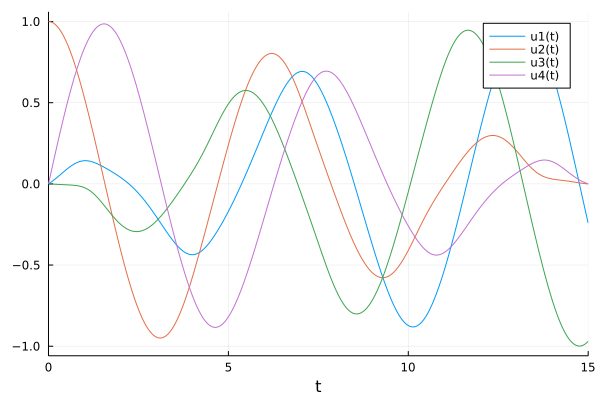

In [17]:
plot(al)

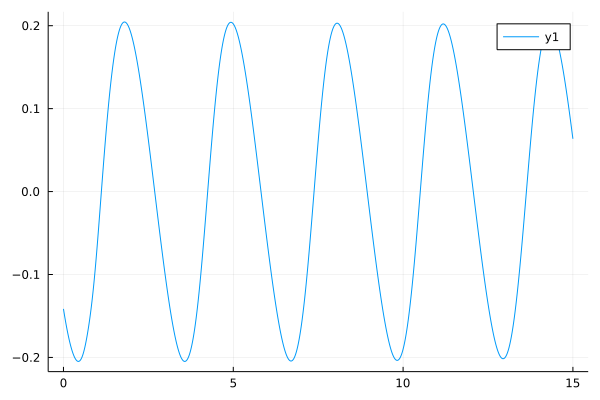

In [18]:
plot(tt,utt)

In [19]:
using MAT

file = matopen("Uopt.mat", "w")
write(file, "Uopt", utt)
close(file)

In [20]:
CostH

10-element Vector{Float64}:
 0.007155180427779317
 0.002408869332067506
 0.0024072548036667596
 0.001641370981375829
 0.0018757984604352337
 0.0016083843604033042
 0.0016035691735175792
 0.0016052638823666938
 0.0
 0.0